In [1]:
import math
import matplotlib.pyplot as plt

import torch

import pennylane as qml
from pennylane import numpy as np
import sklearn

import time
import warnings
warnings.filterwarnings("ignore")

In [2]:
# device = torch.device("mps" if torch.mps.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

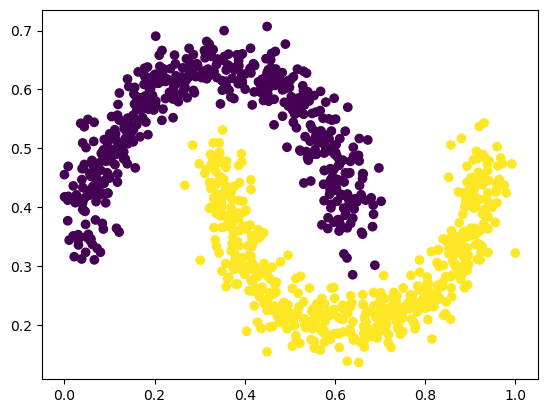

In [3]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons

# Generate and preprocess the dataset
dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.1, random_state=None)

dtype = torch.get_default_dtype()
torch.set_default_dtype(dtype)
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label[:, None]).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_label[:, None]).type(dtype).to(device)

# Visualize the dataset
X = dataset['train_input']
y = dataset['train_label']

x_min = torch.min(X)
x_max = torch.max(X)

X = (X - x_min) / (x_max - x_min)

plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())
plt.show()


batch_size = 100
train_loader = torch.utils.data.DataLoader(list(zip(X, y)), batch_size=batch_size, shuffle=True)


X_test = dataset['test_input']
Y_test = dataset['test_label']

x_min = torch.min(X_test)
x_max = torch.max(X_test)
X_test = (X_test - x_min) / (x_max - x_min)

test_loader = torch.utils.data.DataLoader(list(zip(X_test, Y_test)), batch_size=batch_size, shuffle=False)


In [4]:
# X0list = []
# X1list = []
# for x,y in train_loader:
#     # print(f"X: {x.shape}, y: {y.shape}")
#     X0 = x[np.where(y==0.)[0]]
#     X1 = x[np.where(y==1.)[0]]
#     for element in X0:
#         element /= torch.norm(element)
#         rho = torch.outer(element.conj(), element)
#         X0list.append(rho)
#     for element in X1:
#         element /= torch.norm(element)
#         rho = torch.outer(element.conj(), element)
#         X1list.append(rho)

# rhox0 = torch.mean(torch.stack(X0list), dim=0)
# rhox1 = torch.mean(torch.stack(X1list), dim=0)
# tr = torch.trace(np.abs(rhox0 - rhox1)) * 0.5
# helm_bound = 0.5 + (0.5 * tr)
# print("Helm Bound:", helm_bound.item())

In [21]:
n_qubits = 4
total_qubits = 4    ##### Change this to 8 if u want to use the ancillas
folds = 4
dev = qml.device("lightning.qubit", wires=total_qubits, c_dtype=np.complex64)

def strongly_entangling_layer(params, total_qubits=n_qubits):

    for i in range(total_qubits):
        qml.RY(params[i], wires=[i])
    for i in range(total_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[total_qubits - 1, 0])

def zz_featuremap(data_point):

    for i in range(len(data_point)):
        qml.Hadamard(wires=[i])
        qml.PhaseShift(2 * data_point[i], wires=[i])
    qml.CNOT(wires=[0,1])
    qml.PhaseShift(2 * (math.pi - data_point[0]) * (math.pi - data_point[1]), wires=1)
    qml.CNOT(wires=[0,1])

    
@qml.qnode(dev, interface="torch")
def circuit(data_point, params, folds=folds):
    # qml.AmplitudeEmbedding(features=data_point, wires=[0], pad_with=0., normalize=True)
    # zz_featuremap(data_point)
    qml.AngleEmbedding(features=data_point, wires=range(2), rotation="Y")

    for i in range(folds):
        strongly_entangling_layer(params[i], total_qubits=n_qubits)

    output = qml.expval(qml.PauliZ(wires=[0]))

    return output

In [22]:
class BatchLossModel(torch.nn.Module):

    def __init__(self, params):
        super().__init__()
        self.params = params

    def forward(self,x):
        outputs = torch.stack([circuit(x[i].cpu(), self.params.cpu()) for i in range(x.shape[0])])
        return outputs.to(device, dtype=dtype)

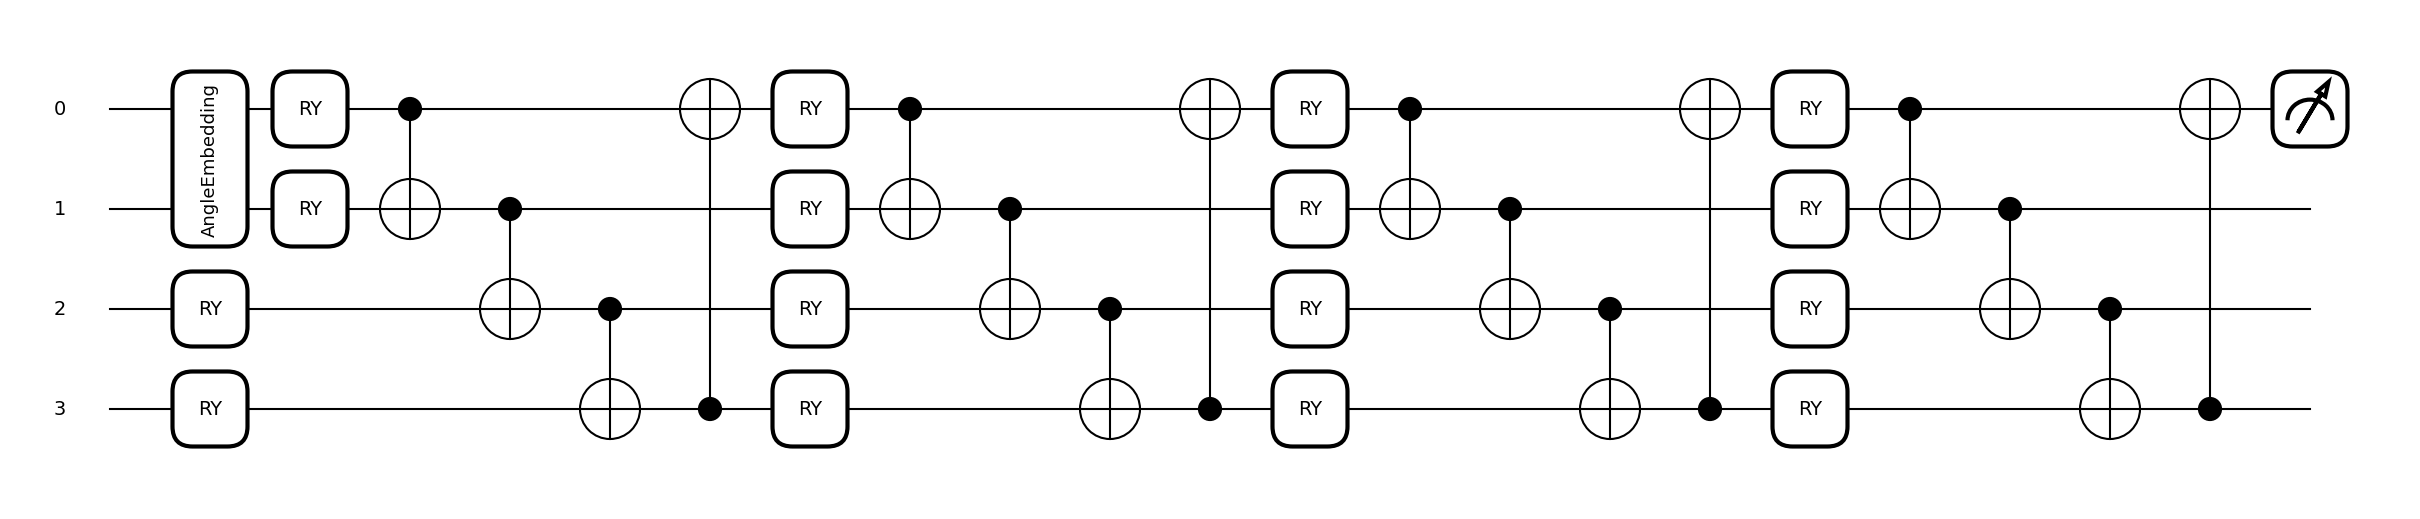

In [23]:
# use seed for reproducibility
torch.manual_seed(42)
input_params = torch.rand((folds, total_qubits), requires_grad=True, dtype=dtype, device=device)

qml.draw_mpl(circuit, device='default')(X[0],input_params)
plt.show()

In [24]:
weights = input_params
lr = 0.01

model = BatchLossModel(weights)
opt = torch.optim.Adam([weights], lr=lr)
loss_fn = torch.nn.BCEWithLogitsLoss()

loss_history = []
min_loss = float('inf')
optimal_params = torch.zeros((folds, total_qubits), dtype=dtype, device=device)
n_epochs = 40
i = 0

while i < n_epochs:
    running_loss = 0.0

    start_time = time.time()
    for batch_x, batch_y in train_loader:
        
        opt.zero_grad()
        circuit_outputs = (model(batch_x) + 1)/2
        loss = loss_fn(circuit_outputs, batch_y.squeeze(1))
        loss.backward()
        opt.step()

        running_loss += loss.item()
    end_time = time.time()

    print(f"Epoch: {i+1} Loss: {running_loss} Time taken per epoch: {end_time - start_time} seconds")

    i += 1
    loss_history.append(running_loss)
    if running_loss < min_loss:
        min_loss = running_loss
        optimal_params = weights.detach().clone()

Epoch: 1 Loss: 7.3996217250823975 Time taken per epoch: 3.7919228076934814 seconds
Epoch: 2 Loss: 7.104224920272827 Time taken per epoch: 3.5825748443603516 seconds
Epoch: 3 Loss: 6.94566935300827 Time taken per epoch: 3.5619583129882812 seconds
Epoch: 4 Loss: 6.87707257270813 Time taken per epoch: 3.4531352519989014 seconds
Epoch: 5 Loss: 6.8418697118759155 Time taken per epoch: 3.636453866958618 seconds
Epoch: 6 Loss: 6.816080749034882 Time taken per epoch: 3.6576833724975586 seconds
Epoch: 7 Loss: 6.79659777879715 Time taken per epoch: 3.7314419746398926 seconds
Epoch: 8 Loss: 6.779507339000702 Time taken per epoch: 3.6609458923339844 seconds
Epoch: 9 Loss: 6.766447484493256 Time taken per epoch: 3.5880751609802246 seconds
Epoch: 10 Loss: 6.752463757991791 Time taken per epoch: 3.6647121906280518 seconds
Epoch: 11 Loss: 6.741404175758362 Time taken per epoch: 3.5767288208007812 seconds
Epoch: 12 Loss: 6.7326770424842834 Time taken per epoch: 3.6547977924346924 seconds
Epoch: 13 Loss

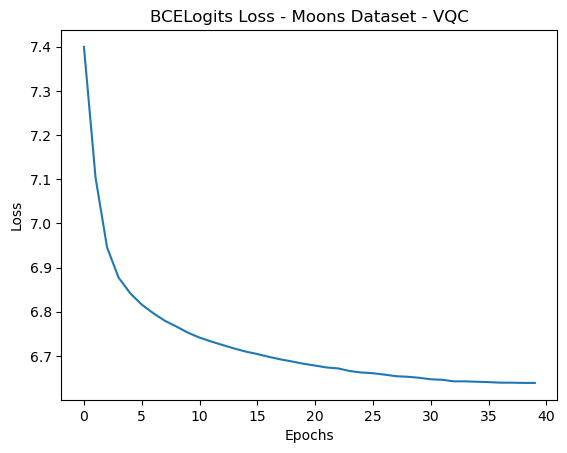

In [25]:
plt.plot(loss_history)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BCELogits Loss - Moons Dataset - VQC')
plt.show()

In [26]:
from sklearn.metrics import accuracy_score


model.eval()

all_train_preds = []
all_train_labels = []

with torch.no_grad(): 
    for batch_x, batch_y in train_loader:
        
        outputs = model(batch_x)
        preds = torch.sigmoid(outputs) > 0.5

        all_train_preds.append(preds.cpu())
        all_train_labels.append(batch_y.squeeze(1).cpu())

all_train_preds = torch.cat(all_train_preds)
all_train_labels = torch.cat(all_train_labels)


train_accuracy = accuracy_score(all_train_labels.numpy(), all_train_preds.numpy())

print(f"Train Accuracy: {train_accuracy * 100}%")

Train Accuracy: 50.0%


In [27]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:

        outputs = model(batch_x)
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.append(preds.cpu())
        all_labels.append(batch_y.squeeze(1).cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy())    
print(f"Test Accuracy: {accuracy * 100}%")

Test Accuracy: 50.0%


In [19]:
###### Decision Boundary of the trained model
model.eval()

# Get training data for plotting
X_train = X
y_train = y

### build a dense 2-D mesh that covers the feature space
x_min, x_max = X_train[:,0].min()-0.1, X_train[:,0].max()+0.1
y_min, y_max = X_train[:,1].min()-0.1, X_train[:,1].max()+0.1

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid   = np.c_[xx.ravel(), yy.ravel()]            # shape (M,2)


### evaluate the trained model ONCE on that grid
g = torch.tensor(grid, dtype=dtype,device=device)

with torch.no_grad():

    logits = model(g)                         # (B,1) or (B,)
    probs  = torch.sigmoid(logits).cpu().numpy().reshape(xx.shape)


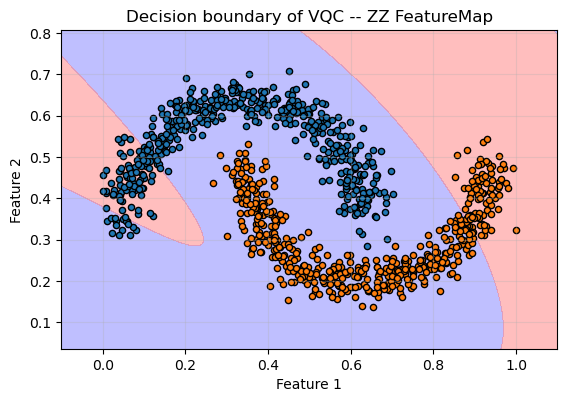

In [28]:
# plt.figure(figsize=(8, 6))

plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.5, cmap='bwr')
plt.scatter(X[y[:,0]==0, 0], X[y[:,0]==0, 1],
            cmap='bwr', edgecolors='k', s=20)
plt.scatter(X[y[:,0]==1, 0], X[y[:,0]==1, 1],
            cmap='bwr', edgecolors='k', s=20)
# plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:,0].cpu().detach().numpy())

plt.xlim(xx.min(), xx.max());  plt.ylim(yy.min(), yy.max())
plt.gca().set_aspect("equal")
plt.grid(True, alpha=0.3);
plt.title("Decision boundary of VQC -- ZZ FeatureMap")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

